## TSP path overlaid on a map of the ethiopia & their capitals.

###  ADDIS ABABA UNIVERSITY 
    
###  ADDIS ABABA INSTITUTE OF TECHNOLOGY
    
####  SCHOOL OF INFORMATION TECHNOLOGY AND ENGINEERING – SITE
    
####  Department of MSC in Artificial Intelligence                                           



### Course Assignment       
>>###### Course:  Distributed Computing For AI
>>###### Name1:    Mintesnot Fikir   GSR1669/15
>>###### Name2:    Ermias Alemayehu  GSR8636/15
>>###### Name3:    Migbar Abera      GSR3053/15
>>###### Section: Regular   
>>###### Submitted to: Beakal Gizachew(PhD)
>>###### Submission date January 202024

In [45]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Eth_map = mpimg.imread("ethiomap.jpg")
def show_cities(path, w=12, h=8):
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]    
    plt.imshow(Eth_map) 
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)    
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the Ethiopia & city"""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = starting_city
    (x0, y0) = starting_city
    plt.imshow(Eth_map)
    #plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    
    
def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])
    
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)        
    plt.title(" + ".join(reversed(terms)))  

21


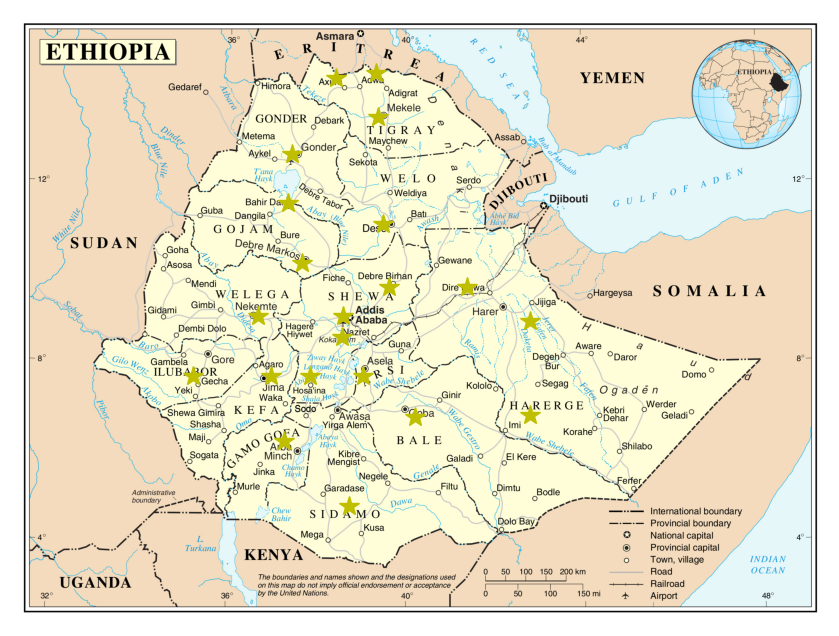

In [27]:
cities = {"Gondar": (1080, 550),"Mekele": (1410, 410),"Adwa": (1400, 240),"Axum": (1250, 260),"Debre Markos": (1120, 970),"Dese": (1430, 820)\
         ,"Bahir Dar": (1065, 740),"Debre Birhan": (1450, 1060),"Jima": (1000, 1400),"Arba Minch": (1050, 1650),"Ilubabor": (700, 1400)\
        ,"Hosaina": (1150, 1400),"Sidamo": (1300, 1900),"Arisi": (1350, 1400), "Addis Ababa": (1277, 1172),"Welega": (950, 1172),"Nazret": (1272, 1252)\
        ,"Dire Dawa": (1750, 1060),"Jigjiga": (1990, 1190),"Harerge": (1990, 1550),"Bale": (1550, 1560)}


cities = list(sorted(cities.items()))
print(len(cities))
show_cities(cities)

16515

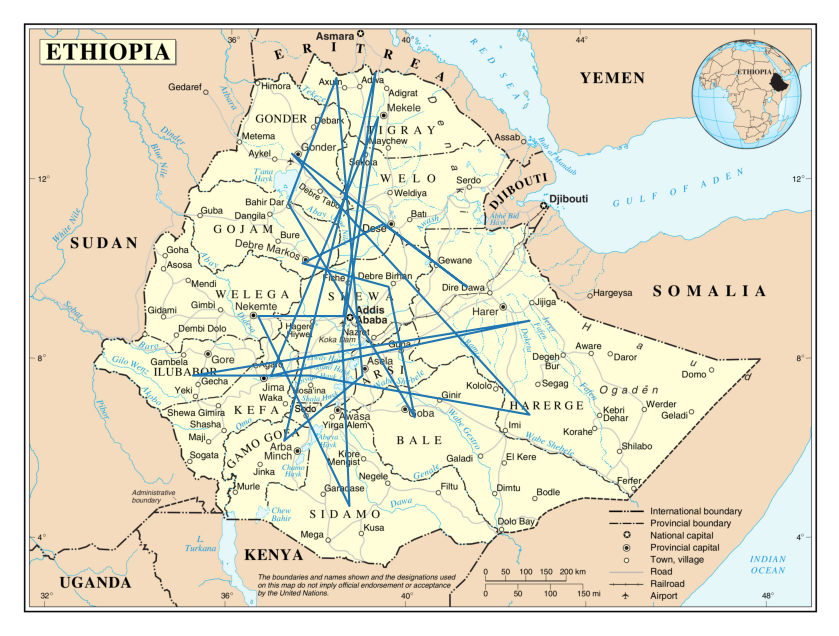

In [29]:
show_path(cities)
path_distance(cities)

## We implemented the following equations 

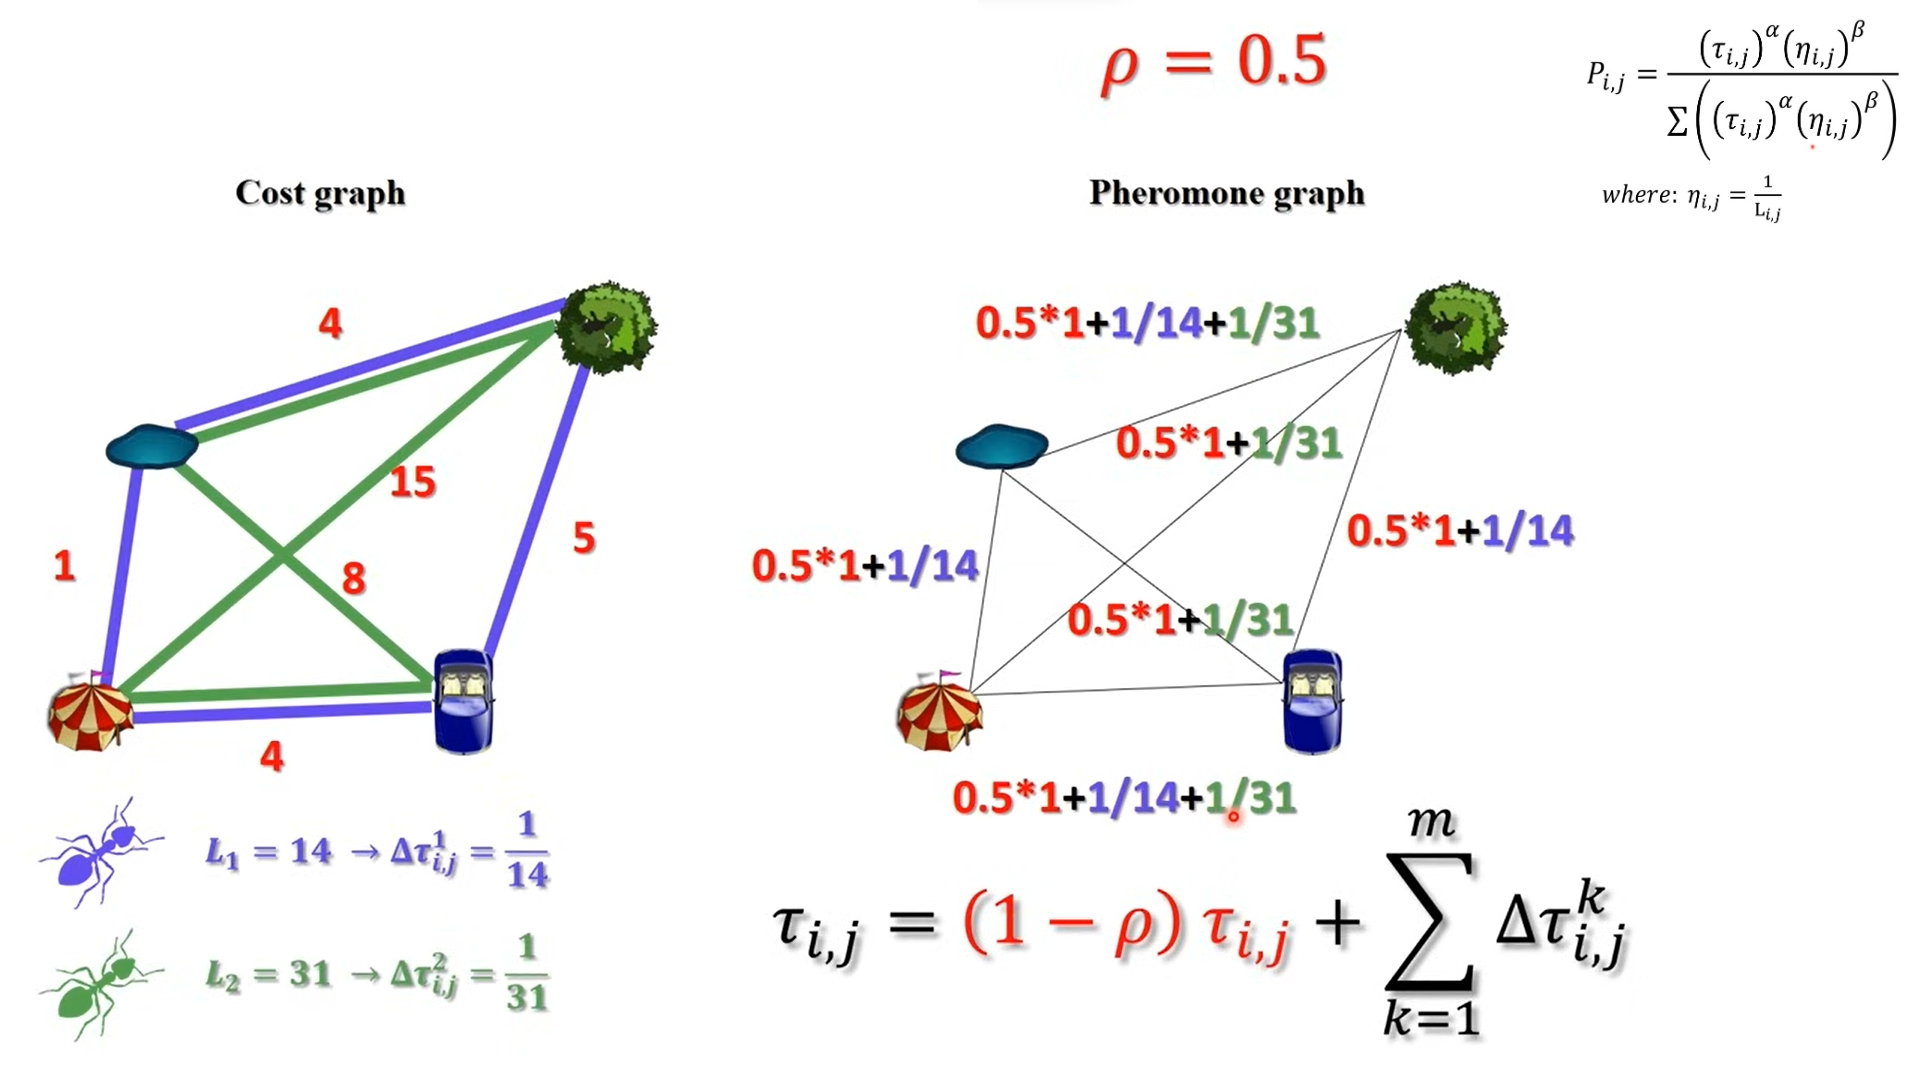

In [30]:
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )


def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   
    return int(sum(
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                  
    ))

In [31]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union
import numpy as np
import random

class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]],                         
                 
                 time=0,                 
                 min_time=0,              
                 timeout=0,              
                 stop_factor=2,          
                 min_round_trips=10,      
                 max_round_trips=0,                       
                 min_ants=0,              
                 max_ants=0,              
                 
                 ant_count=64,           
                 ant_speed=1,             

                 distance_power=1,                   
                 pheromone_power=1.25,    
                 decay_power=0,           
                 reward_power=0,          
                 best_path_smell=2,                        
                 start_smell=0,           

                 verbose=False,

    ):
        assert callable(cost_fn)        
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)
    
        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)
        
        self.distance_power  = float(distance_power)     
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        
        self.verbose         = int(verbose)
        self._initalized     = False
        
        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }


        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }


        self.pheromones = {
            source: {

                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }

        
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))
        

        
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True        


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

            
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1


            
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue 
                
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)


                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })


                            
                            
                            
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1
            if not len(best_epochs): continue 
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue        
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break               
            if self.min_ants and self.ants_used <  self.min_ants: continue        
            if self.max_ants and self.ants_used >= self.max_ants: break            
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break                                
            if True: continue
            
            
            
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path

    
    
    
    

    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node
            
        
def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }
        
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result

{'path_cost': 10467, 'ants_used': 1, 'epoch': 9741, 'round_trips': 1, 'clock': 0}
{'path_cost': 8948, 'ants_used': 65, 'epoch': 18882, 'round_trips': 2, 'clock': 0}
{'path_cost': 8226, 'ants_used': 90, 'epoch': 22044, 'round_trips': 2, 'clock': 0}
{'path_cost': 8156, 'ants_used': 141, 'epoch': 30510, 'round_trips': 3, 'clock': 0}
{'path_cost': 7883, 'ants_used': 162, 'epoch': 31516, 'round_trips': 3, 'clock': 0}
{'path_cost': 7010, 'ants_used': 196, 'epoch': 37738, 'round_trips': 4, 'clock': 0}
{'path_cost': 6986, 'ants_used': 256, 'epoch': 44559, 'round_trips': 5, 'clock': 0}
{'path_cost': 6777, 'ants_used': 275, 'epoch': 46650, 'round_trips': 5, 'clock': 0}
{'path_cost': 6629, 'ants_used': 318, 'epoch': 51970, 'round_trips': 6, 'clock': 0}
{'path_cost': 6405, 'ants_used': 371, 'epoch': 56417, 'round_trips': 6, 'clock': 1}
{'path_cost': 6272, 'ants_used': 414, 'epoch': 61366, 'round_trips': 7, 'clock': 1}
{'path_cost': 6212, 'ants_used': 454, 'epoch': 65760, 'round_trips': 8, 'clock':

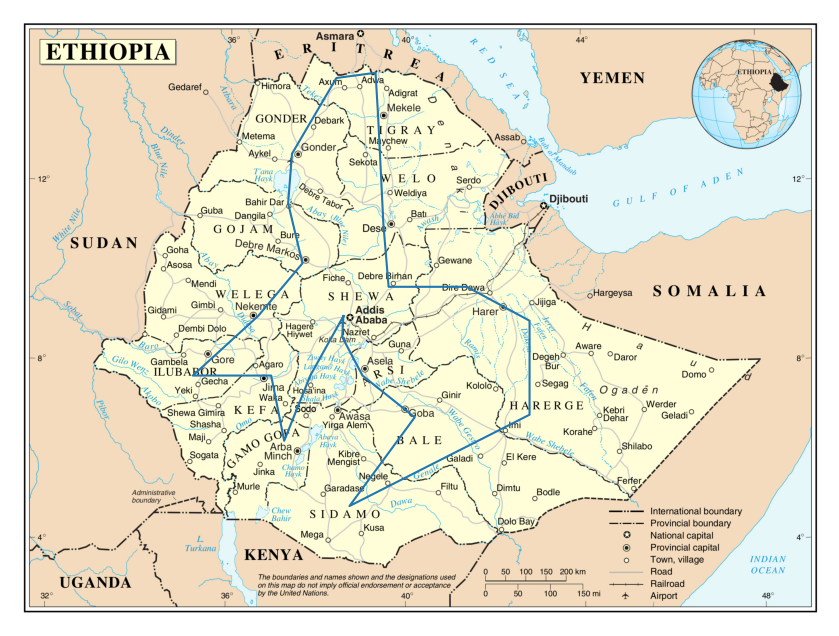

In [32]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)

Running Ant Colony Optimization...
{'path_cost': 9456, 'ants_used': 1, 'epoch': 8977, 'round_trips': 1, 'clock': 0}
{'path_cost': 9145, 'ants_used': 68, 'epoch': 19957, 'round_trips': 2, 'clock': 0}
{'path_cost': 7559, 'ants_used': 129, 'epoch': 28842, 'round_trips': 3, 'clock': 0}
{'path_cost': 7092, 'ants_used': 195, 'epoch': 37754, 'round_trips': 4, 'clock': 0}
{'path_cost': 6904, 'ants_used': 320, 'epoch': 53397, 'round_trips': 6, 'clock': 0}
{'path_cost': 6598, 'ants_used': 335, 'epoch': 56014, 'round_trips': 6, 'clock': 0}
{'path_cost': 6322, 'ants_used': 365, 'epoch': 59394, 'round_trips': 7, 'clock': 1}
{'path_cost': 6011, 'ants_used': 391, 'epoch': 62027, 'round_trips': 7, 'clock': 1}
{'path_cost': 6008, 'ants_used': 421, 'epoch': 65285, 'round_trips': 7, 'clock': 1}
{'path_cost': 5899, 'ants_used': 507, 'epoch': 73117, 'round_trips': 9, 'clock': 1}
N=21  | 16515 -> 5906 |    3s | ants:  1310 | trips:   22 | 

Running Bee Algorithm...

Results:
ACO Best Path Distance: 5906
BA 

C:\Users\minte\AppData\Local\Temp\ipykernel_13248\382892794.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


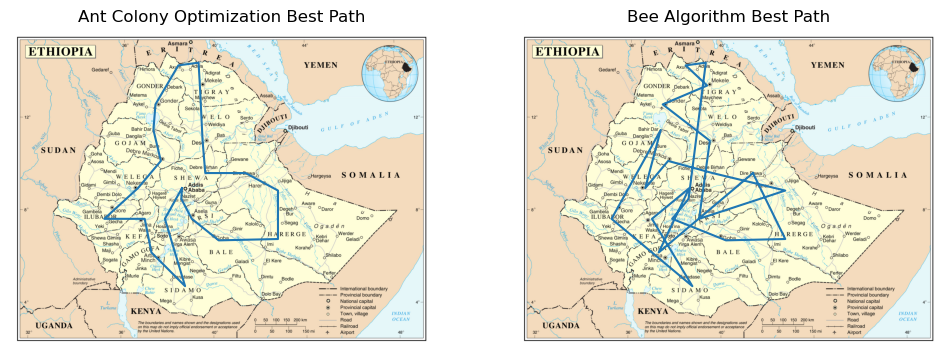

In [33]:
class BeeAlgorithmSolver:
    def __init__(self, cost_fn, num_bees=30, max_iterations=50):
        self.cost_fn = cost_fn
        self.num_bees = num_bees
        self.max_iterations = max_iterations
        self.best_solution = None
        self.best_cost = float('inf')

    def initialize_population(self, problem_path):
        population = [random.sample(problem_path, len(problem_path)) for _ in range(self.num_bees)]
        return population

    def find_best_solution(self, population):
        for solution in population:
            cost = path_distance(solution)
            if cost < self.best_cost:
                self.best_cost = cost
                self.best_solution = solution

    def mutate_solution(self, solution):
        idx1, idx2 = random.sample(range(len(solution)), 2)
        solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
        return solution

    def solve(self, problem_path):
        population = self.initialize_population(problem_path)
        for _ in range(self.max_iterations):
            new_population = [self.mutate_solution(solution.copy()) for solution in population]
            self.find_best_solution(new_population + population)
            population = new_population
        return self.best_solution

def run_and_compare_algorithms(cities):
    cities_list = [city[1] for city in cities]

    # Ant Colony Optimization Run
    print("Running Ant Colony Optimization...")
    aco_solver = AntColonySolver(distance, verbose=True)
    aco_result = AntColonyRunner(cities_list, verbose=True, plot=True)

    # Bee Algorithm Run
    print("\nRunning Bee Algorithm...")
    ba_solver = BeeAlgorithmSolver(distance, num_bees=30, max_iterations=50)
    ba_result = ba_solver.solve(cities_list)

    # Results
    print("\nResults:")
    print(f"ACO Best Path Distance: {path_distance(aco_result)}")
    print(f"BA Best Path Distance: {path_distance(ba_result)}")
    print("\nVisualizing the best paths found by each algorithm...")


    plt.subplot(1, 2, 1)
    plt.title("Ant Colony Optimization Best Path")
    show_path(aco_result)

    plt.subplot(1, 2, 2)
    plt.title("Bee Algorithm Best Path")
    show_path(ba_result)

    plt.show()
run_and_compare_algorithms(cities)

N=5   |  4840 -> 3125 |    0s | ants:   555 | trips:   10 | distance_power=1
N=10  |  6975 -> 3617 |    1s | ants:   553 | trips:   10 | distance_power=1
N=15  | 11109 -> 5359 |    1s | ants:   572 | trips:   10 | distance_power=1
N=20  | 16109 -> 5780 |    1s | ants:   549 | trips:   10 | distance_power=1
N=21  | 16515 -> 6190 |    5s | ants:  2617 | trips:   42 | distance_power=1


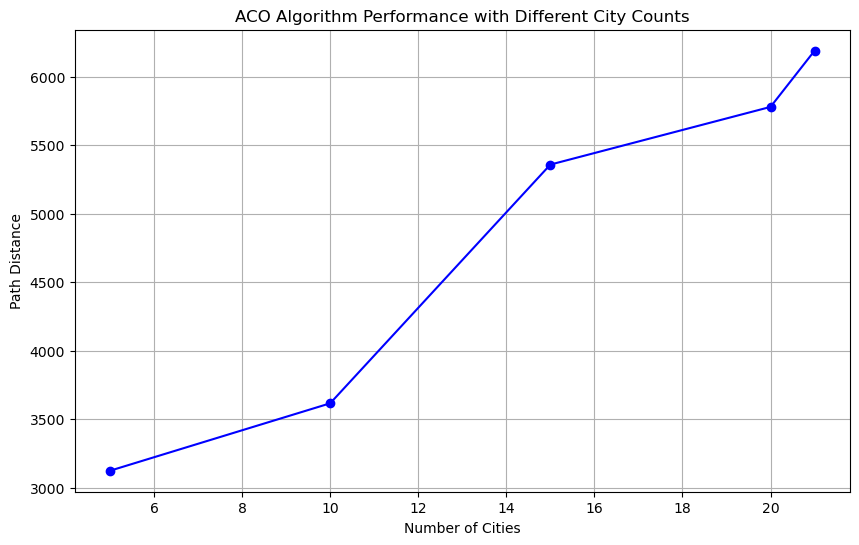

In [44]:
cities_list = [city[1] for city in cities]
def run_aco_with_different_cities(cities_list, city_counts, **kwargs):
    results = []
    for count in city_counts:
        subset_cities = cities_list[:count]  
        result_path = AntColonyRunner(subset_cities, **kwargs)
        result_distance = path_distance(result_path)
        results.append((count, result_distance))
    
    return results
def plot_aco_results(results):
    cities_count = [result[0] for result in results]
    distances = [result[1] for result in results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(cities_count, distances, marker='o', linestyle='-', color='b')
    plt.title("ACO Algorithm Performance with Different City Counts")
    plt.xlabel("Number of Cities")
    plt.ylabel("Path Distance")
    plt.grid(True)
    plt.show()


city_counts = [5, 10, 15, 20, 21]  

aco_results = run_aco_with_different_cities(cities_list, city_counts, distance_power=1, verbose=False, plot=False)

plot_aco_results(aco_results)

Running ACO with config: {'ant_count': 20, 'pheromone_power': 1.0, 'distance_power': 1}
N=21  | 16515 -> 7319 |    1s | ants:   179 | trips:   10 | ant_count=20 pheromone_power=1.0 distance_power=1
Running ACO with config: {'ant_count': 40, 'pheromone_power': 1.0, 'distance_power': 1}
N=21  | 16515 -> 6039 |    6s | ants:  2252 | trips:   58 | ant_count=40 pheromone_power=1.0 distance_power=1
Running ACO with config: {'ant_count': 60, 'pheromone_power': 1.0, 'distance_power': 1}
N=21  | 16515 -> 5803 |    5s | ants:  2237 | trips:   39 | ant_count=60 pheromone_power=1.0 distance_power=1
Running ACO with config: {'ant_count': 20, 'pheromone_power': 2.0, 'distance_power': 2}
N=21  | 16515 -> 5739 |    2s | ants:   338 | trips:   18 | ant_count=20 pheromone_power=2.0 distance_power=2
Running ACO with config: {'ant_count': 40, 'pheromone_power': 2.0, 'distance_power': 2}
N=21  | 16515 -> 6270 |    1s | ants:   438 | trips:   11 | ant_count=40 pheromone_power=2.0 distance_power=2
Running AC

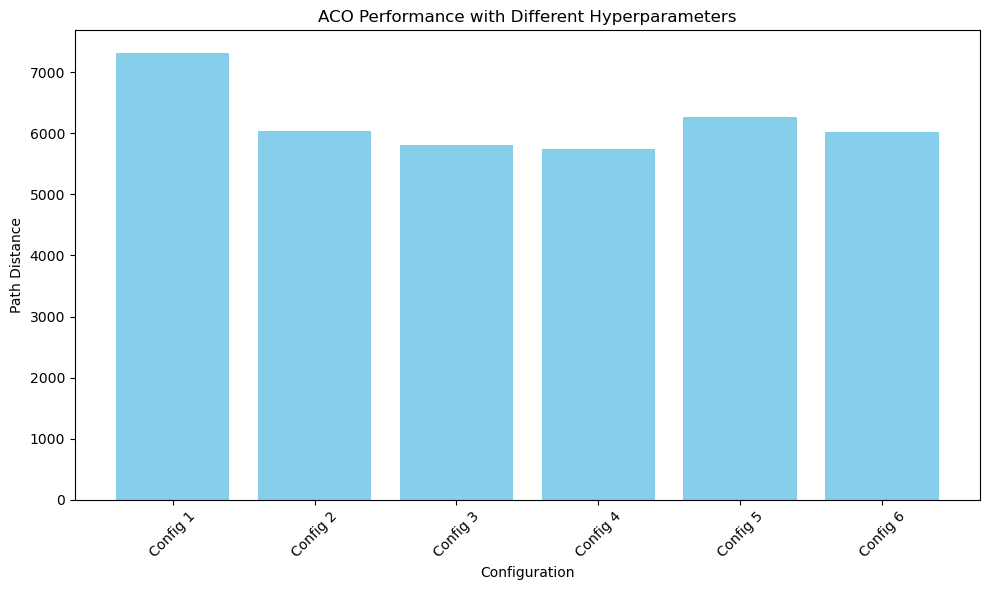

In [36]:
def run_and_evaluate_aco(cities, hyperparameters):
    results = []
    for config in hyperparameters:
        print(f"Running ACO with config: {config}")
        result_path = AntColonyRunner(cities, **config)
        result_distance = path_distance(result_path)
        results.append({
            "config": config,
            "distance": result_distance,
        })
    return results

def plot_hyperparameter_effects(results):
    distances = [result["distance"] for result in results]
    labels = [f"Config {i+1}" for i in range(len(results))]
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, distances, color='skyblue')
    plt.xlabel("Configuration")
    plt.ylabel("Path Distance")
    plt.title("ACO Performance with Different Hyperparameters")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

hyperparameters = [
    {"ant_count": 20, "pheromone_power": 1.0, "distance_power": 1},
    {"ant_count": 40, "pheromone_power": 1.0, "distance_power": 1},
    {"ant_count": 60, "pheromone_power": 1.0, "distance_power": 1},
    {"ant_count": 20, "pheromone_power": 2.0, "distance_power": 2},
    {"ant_count": 40, "pheromone_power": 2.0, "distance_power": 2},
    {"ant_count": 60, "pheromone_power": 2.0, "distance_power": 2},
]

results = run_and_evaluate_aco(cities, hyperparameters)
plot_hyperparameter_effects(results)

N=21  | 16515 -> 6015 |    2s | ants:   742 | trips:   19 | ant_count=40 pheromone_power=2.0 distance_power=2


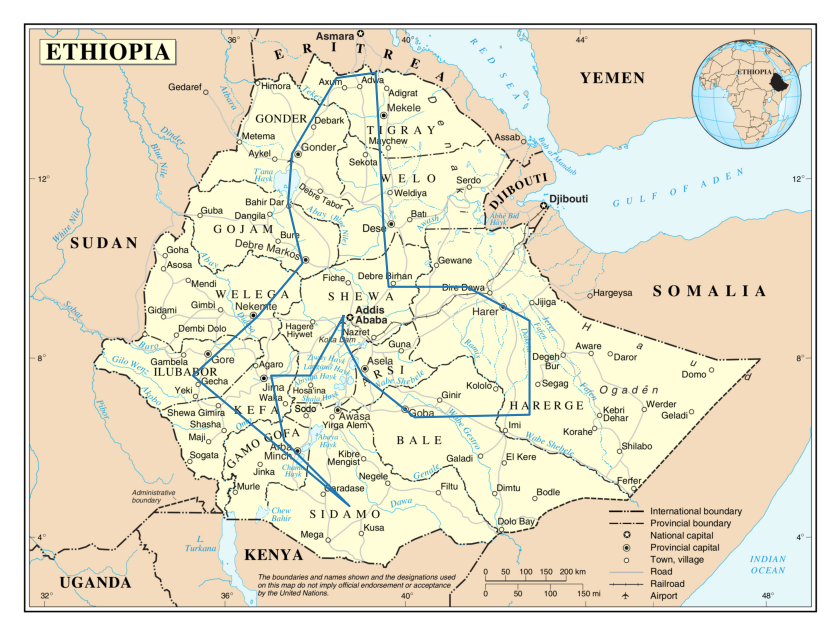

In [42]:
best_hyperparameters = {
    "ant_count": 40,
    "pheromone_power": 2.0,
    "distance_power": 2
}

optimal_path = AntColonyRunner(cities, **best_hyperparameters, verbose=False, plot=False)
show_path(optimal_path)

## Ant Colony Optimization Parameters

In the Ant Colony Optimization (ACO) algorithm, both "pheromone power" and "distance power" are critical parameters that influence the behavior of the artificial ants and the efficiency of the search for an optimal path. These parameters affect the probability calculation for an ant to move from one city to another in the problem space. Let's break down what each term means and how it influences the algorithm:

### Pheromone Power

- **Parameter**: `pheromone_power`
- **Role**: It determines how much influence the pheromone trail level between two cities has on the decision-making process of an ant. In the ACO algorithm, ants are more likely to choose paths with stronger pheromone trails, which are indicative of being part of shorter or more efficient routes discovered by previous ants.
- **Formula Influence**: The probability of choosing the next city is proportional to $(\text{pheromone level})^{\text{pheromone power}}$. A higher `pheromone_power` value makes the ants more likely to follow stronger pheromone trails, thus reinforcing the exploitation of known good paths.
- **Effect**: Increasing `pheromone_power` intensifies the ants' preference for paths with higher pheromone concentrations, potentially speeding up the convergence to a solution but also risking premature convergence to a suboptimal path if diversity is not maintained.

### Distance Power

- **Parameter**: `distance_power`
- **Role**: It determines the influence of the distance between two cities on the ant's decision-making process. The ACO algorithm can balance exploration and exploitation by considering both the attractiveness of short paths (due to shorter distances) and the learned desirability of paths (indicated by pheromone levels).
- **Formula Influence**: The attractiveness of moving to the next city is inversely proportional to $(\text{distance})^{\text{distance power}}$. A higher `distance_power` value makes the ants more likely to prefer shorter paths, independent of the pheromone levels.
- **Effect**: Increasing `distance_power` amplifies the preference for shorter paths, encouraging exploration towards more direct routes between cities. This can help in avoiding local optima by ensuring that the path length remains a significant factor in the decision process.

### Combined Effect in ACO

The ACO algorithm combines these two powers in the decision rule for an ant moving from city $i$ to city $j$, typically in a formula like:

$$
P(i,j) = \frac{{[\tau(i,j)]^{\text{pheromone power}} \cdot [\eta(i,j)]^{\text{distance power}}}}{{\sum{[\tau(i,k)]^{\text{pheromone power}} \cdot [\eta(i,k)]^{\text{distance power}}}}}
$$

where:
- $P(i,j)$ is the probability of moving from city $i$ to city $j$,
- $\tau(i,j)$ is the pheromone level on the path from $i$ to $j$,
- $\eta(i,j)$ is the inverse of the distance from $i$ to $j$, serving as a measure of attractiveness,
- The sum in the denominator is over all cities $k$ that have not been visited yet.

Balancing `pheromone_power` and `distance_power` is crucial for effectively navigating the exploration-exploitation trade-off inherent in ACO and other metaheuristic optimization algorithms.


N=21  | 16515 -> 6135 |    6s | ants:  1148 | trips:   60 | ant_count=20 pheromone_power=1.0 distance_power=1
N=21  | 16515 -> 5784 |    3s | ants:  1178 | trips:   30 | ant_count=40 pheromone_power=1.0 distance_power=1
N=21  | 16515 -> 5784 |    3s | ants:  1345 | trips:   24 | ant_count=60 pheromone_power=1.0 distance_power=1
N=21  | 16515 -> 5836 |    1s | ants:   361 | trips:   19 | ant_count=20 pheromone_power=2.0 distance_power=2
N=21  | 16515 -> 5739 |    1s | ants:   435 | trips:   11 | ant_count=40 pheromone_power=2.0 distance_power=2
N=21  | 16515 -> 5969 |    2s | ants:   729 | trips:   13 | ant_count=60 pheromone_power=2.0 distance_power=2


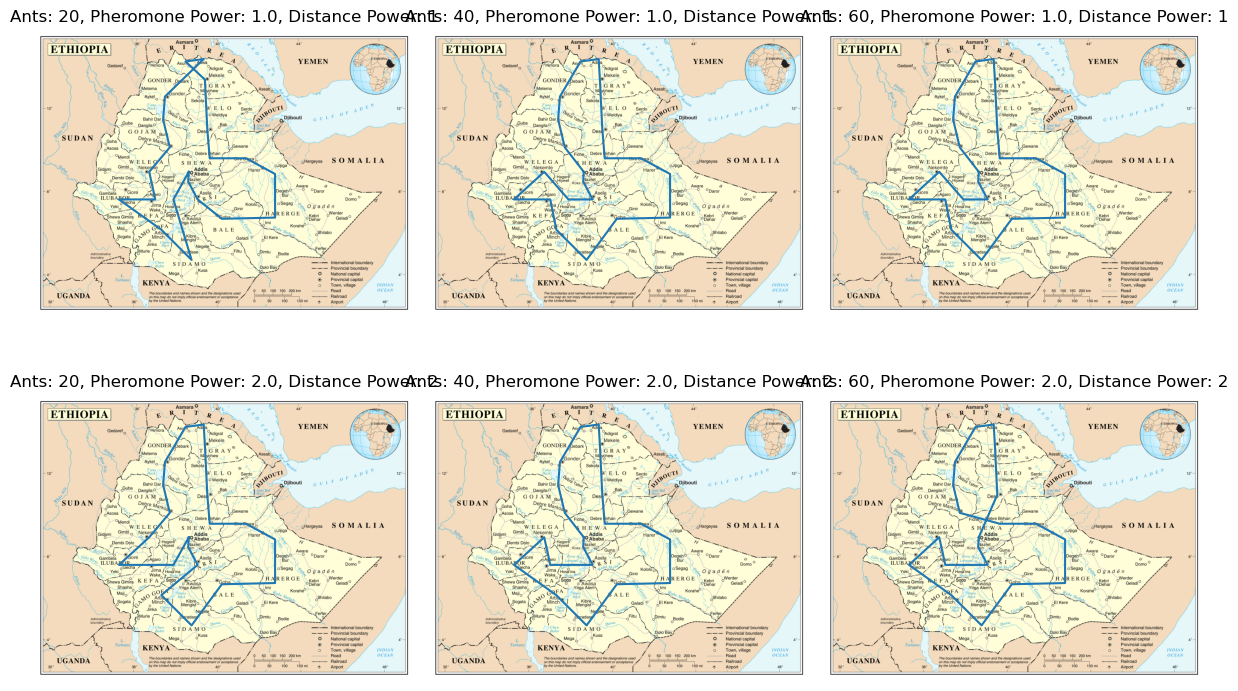

In [39]:
import matplotlib.pyplot as plt

# Hyperparameter configurations
hyperparameters = [
    {"ant_count": 20, "pheromone_power": 1.0, "distance_power": 1},
    {"ant_count": 40, "pheromone_power": 1.0, "distance_power": 1},
    {"ant_count": 60, "pheromone_power": 1.0, "distance_power": 1},
    {"ant_count": 20, "pheromone_power": 2.0, "distance_power": 2},
    {"ant_count": 40, "pheromone_power": 2.0, "distance_power": 2},
    {"ant_count": 60, "pheromone_power": 2.0, "distance_power": 2},
]


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12)) 
axes = axes.flatten() 

for i, config in enumerate(hyperparameters):

    optimal_path = AntColonyRunner(cities, **config, verbose=False, plot=False)

    plt.sca(axes[i])
    

    show_path(optimal_path)

    title = f"Ants: {config['ant_count']}, Pheromone Power: {config['pheromone_power']}, Distance Power: {config['distance_power']}"
    plt.title(title)

plt.tight_layout()
plt.show()

N=21  | 16515 -> 6201 |    1s | ants:   360 | trips:   10 | ant_count=40 pheromone_power=2.0 distance_power=2


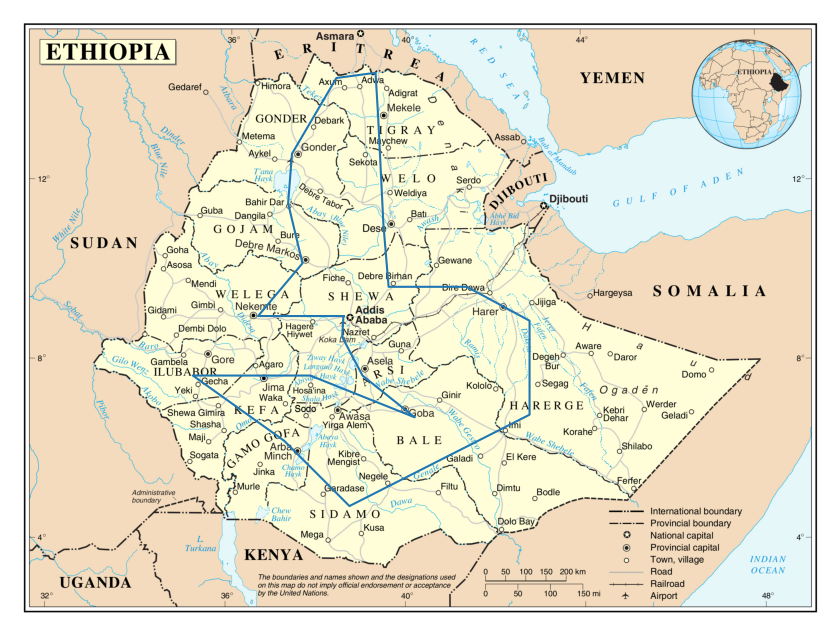

In [41]:
# With Best hyperparameters
best_hyperparameters = {
    "ant_count": 40,
    "pheromone_power": 2.0,
    "distance_power": 2
}

optimal_path = AntColonyRunner(cities, **best_hyperparameters, verbose=False, plot=False)
show_path(optimal_path)
plt.show()